- [ ] implement ITIs properly (either with the help of optseq2 or simply from a histogram between 4 and 12 of an exponential distribution)
	- [ ] 3 levels: exact distribution, noise level, randomization of trials
	- [x] get a hist
	- [x] randomize
	- [x] convolve linearly scaled signal response amplitudes with HRF
		- [x] long one: two-gamma with back to baseline after 20s
	- [x] deconvolve or GLM it
	- [ ] noise could be a specific autocrrelated noise, ie Riemann noise with scipy
    - [ ] can I recover the different response amplitudes in beta-weights?

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.special import gamma


In [2]:
# in numpy, histograms are tuples of values/bins
np.histogram([1, 2, 1], bins=[0, 1, 2, 3])

(array([0, 2, 1]), array([0, 1, 2, 3]))

In [3]:
# Tomas' basic exponential histogram over ITI values 1-20
basic_hist = (np.array([20, 10, 5, 2, 1, 1, 0, 0, 0]), np.array([4, 5, 6, 7, 8, 9, 10, 11, 12]))

<BarContainer object of 9 artists>

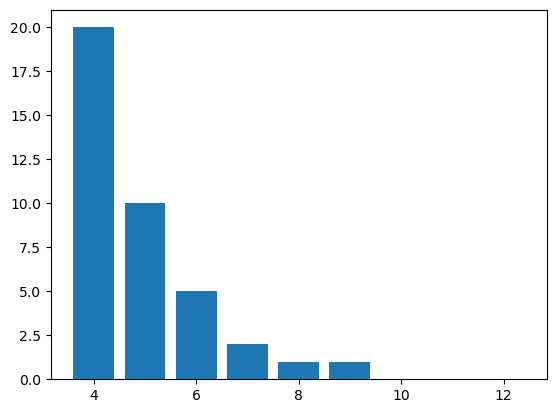

In [4]:
plt.bar(basic_hist[1],basic_hist[0])

In [147]:
# trials is a mapping between trial types and the corresponding amplitude scaling factor 
trials = {"dur_0" : 0,
         "dur_17" : 1,
         "dur_33" : 2,
         "dur_67" : 3,
         "dur_134" : 4,
         "dur_267-isi_0" : 5,
         "dur_533" : 6,
         "isi_17" : 5,
         "isi_33" : 5.1,
         "isi_67" : 5.3,
         "isi_134" : 5.5,
         "isi_267" : 5.8,
         "isi_533" : 6}

def make_hist(n_trials = 39):
    """
    takes the basic histogram and potentially shifts things around a bit
    
    TODO implement the actual shifting around
    """
    
    basic_hist = (np.array([20, 10, 5, 2, 1, 1, 0, 0, 0]), np.array([4, 5, 6, 7, 8, 9, 10, 11, 12]))
    
    hist = basic_hist
    
    return hist

def randomize_trials(hist_tup):
    """
    takes an ITI distribution tuple of (n_ITIs, bins [seconds])
    returns a randomized trial sequence
    """
    # first, make a sequence list
    sequence_list = [[tup[1]]*tup[0] for tup in list(zip(hist_tup[0], hist_tup[1]))]
    sequence_list = [val for sublist in sequence_list for val in sublist]

    random.shuffle(sequence_list) # shuffle inplace
        
    return sequence_list

def unfold_upsample(sequence_list, upsample_factor = 10):
    """
    takes a sequence list and then unfolds and upsamples it by some factor
    """
    # unfold
    seq_array = np.zeros(sum(sequence_list))
    
    # cumsum gives basically the end indeces of the trials, we drop the last and add a 0 in front 
    idxs = np.cumsum([0] + sequence_list)[:-1] # cumsum gives basically the end times of the trials, we drop the last and add a 0 in front 
    seq_array[idxs] = 1
    
    # upsample
    seq_array = np.repeat(seq_array, upsample_factor)
    for i, element in enumerate(seq_array):
        if element == 1: # detect a one

            for k in range(1,upsample_factor): # set the following k to 0
                #print(k)
                seq_array[i+k] = 0
    
    return seq_array

    
def scale_amplitudes(seq_array, trials = trials, n_repeats = 3):
    """
    takes a trial sequence and scales the signal amplitudes according to some experimental design 
    trials is a dict with the different trial types and their amplitudes
    
    returns appropriately scaled trials and dict specifying when each trial event happened
    """
    event_types = {}
    design = list(trials.keys()) * n_repeats # 3 repeats
    random.shuffle(design)
    
    j = 0 # index for design
    out_array = np.zeros_like(seq_array)
#     print(seq_array, trials)
    # match repeats with 1's
    for i, event in enumerate(seq_array):
        if event == 1:  # check if event occured
#             print(f"at index {i}, found value {event}, putting value {event} * {trials[design[j]]}, since this is {design[j]}")
            # multiply with trial amplitude
            out_array[i] = event * trials[design[j]]
            # save i:event
            event_types[i] = design[j]
            # increase counter
            j += 1
            
    return out_array, event_types

def plot_trial_sequence(scaled_events, events_dict):
    # Create a list of indices where the value is 1
    events_indices = list(events_dict.keys())

    # Plotting the vertical lines at the indices where the value is 1
    fig, ax = plt.subplots()
    for i in events_indices:
        ax.vlines(i, ymin=0, ymax=scaled_events[i], colors='r', linestyles='solid', label='Vertical Lines (1s)')
    ax.set_xticks(events_indices)
    ax.set_xticklabels(list(events_dict.values()), rotation = 90, size = 8)
    
    return fig, ax


def canHRF(t, a1=6, a2=1, a3=16, a4=1, alpha=1/6):
    """
    makes a canonical two-gamma HRF according to 
    
    $$
    h(t) = \frac{t^{a_1−1}e^{-a_2t}}{\Gamma(a_1)} - \alpha \frac{t^{a_3−1}e^{-a_4t}}{\Gamma(a_3)},
    $$
    
    t is the input time
    a1, a2, a3, a4 are shape params
    alpha controls the ratio of response to undershoot
    
    some plausible parameters are: alpha = 1/6, a1 = 6, 
    a3 = 16 and a2 = a4 = 1, see defaults, 
    which give a nice hrf returning to baseline after 25s
    """
    
    hrf = (t**(a1-1) * np.exp(-a2*t))/gamma(a1) - alpha * (t**(a3-1) * np.exp(-a4*t))/gamma(a3)
    return hrf


def convolve_HRF(trials_scaled, upsample_factor, **kwargs):
    """
    takes a (scaled) trial sequence and convolved it with a twogamma hrf 
    """
    
    t = np.linspace(0, 191, 191 * upsample_factor)
    hrf = canHRF(t)
    trials_scaled_convolved = np.convolve(hrf, trials_scaled, mode='full')

    return trials_scaled_convolved


In [7]:
t = np.linspace(0, 191, 191 * 10)
t.shape

(1910,)

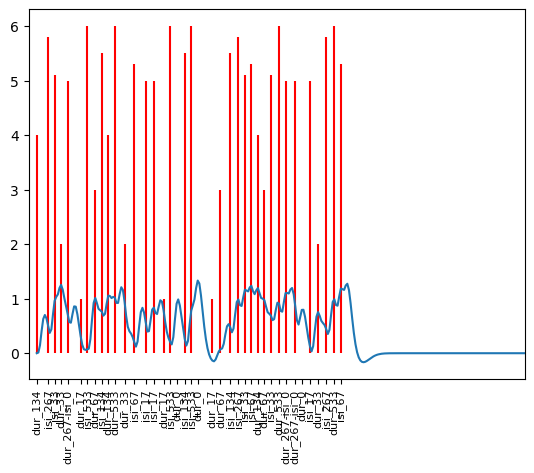

In [212]:
## Testing/putting stuff together
# trials is a mapping between trial types and the corresponding amplitude scaling factor 
trials = {"dur_0" : 0,
         "dur_17" : 1,
         "dur_33" : 2,
         "dur_67" : 3,
         "dur_134" : 4,
         "dur_267-isi_0" : 5,
         "dur_533" : 6,
         "isi_17" : 5,
         "isi_33" : 5.1,
         "isi_67" : 5.3,
         "isi_134" : 5.5,
         "isi_267" : 5.8,
         "isi_533" : 6}

#trials = {"isi_67" : 5.3}

hist = make_hist(n_trials = 2)
hist = (np.array([20, 10, 5, 2, 1, 1, 0, 0, 0]), np.array([4, 5, 6, 7, 8, 9, 10, 11, 12]))
randomized_seq = randomize_trials(hist)
upsampled = unfold_upsample(randomized_seq, upsample_factor = 1)
scaled, events_dict = scale_amplitudes(upsampled, trials = trials)
sc_conv = convolve_HRF(scaled, 1)

events_dict
fig, ax = plot_trial_sequence(scaled, events_dict)
ax.set_xlim(-5, 300)
ax.plot(sc_conv)

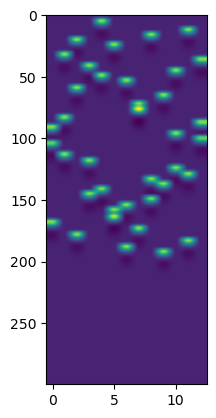

In [213]:
conds = ["dur_0",
         "dur_17",
         "dur_33",
         "dur_67",
         "dur_134",
         "dur_267-isi_0",
         "dur_533",
         "isi_17",
         "isi_33",
         "isi_67",
         "isi_134",
         "isi_267",
         "isi_533"]


def make_design_matrix(events_dict, max_t = 300, conds = ["dur_0", "dur_17", "dur_33", "dur_67", "dur_134",
                                                          "dur_267-isi_0", "dur_533", "isi_17", "isi_33",
                                                          "isi_67", "isi_134", "isi_267", "isi_533"]):
    
    # keep track of conds : tps
    regr_dict = {}
    
    # setup design matrix, shape max_t x len(conds + 1) to keep space for intercept
    design_matrix = np.zeros((max_t, len(conds) + 1))
    
    # for each cond
    for i, cond in enumerate(conds):
        # find timepoints of stimulation
        tps = [key for key, val in events_dict.items() if val == cond]
        regr_dict[cond] = tps
        
        # setup regressor
        regressor = np.zeros(max_t)
        regressor[tps] = 1
        
        # convolve with HRF, cut to max_t, put into matrix
        conv_regressor = convolve_HRF(regressor, 1)[:max_t]
        design_matrix[:,i] = conv_regressor.T 
        
    # column of ones for intercept
    design_matrix[:,-1] = 1
    
    return design_matrix, regr_dict

plt.imshow(make_design_matrix(events_dict)[0][:,:-1], aspect = .1)

In [207]:
import pandas as pd

data = pd.DataFrame(make_design_matrix(events_dict)[0], columns = conds + ['intercept'])
data

,dur_0,dur_17,dur_33,dur_67,dur_134,dur_267-isi_0,dur_533,isi_17,isi_33,isi_67,isi_134,isi_267,isi_533,intercept
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.0
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.130670e-03,0.0,0.000000e+00,0.000000e+00,1.0
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.666123e-02,0.0,0.000000e+00,0.000000e+00,1.0
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.018785e-01,0.0,0.000000e+00,0.000000e+00,1.0
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.571047e-01,0.0,0.000000e+00,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-4.325071e-37,-1.486461e-35,-9.764691e-42,-5.235994e-48,-3.091974e-30,-6.040159e-60,-1.239551e-38,-4.000874e-32,-1.209053e-33,-3.807770e-55,0.0,-1.481981e-51,-3.502395e-40,1.0
296,-1.782012e-37,-6.148264e-36,-3.982116e-42,-2.111463e-48,-1.299262e-30,-2.397600e-60,-5.088659e-39,-1.670978e-32,-5.026980e-34,-1.520041e-55,0.0,-5.944047e-52,-1.432912e-40,1.0
297,-7.335406e-38,-2.540510e-36,-1.622678e-42,-8.509358e-49,-5.452670e-31,-9.512939e-61,-2.087193e-39,-6.970844e-33,-2.087859e-34,-6.064880e-56,0.0,-2.382757e-52,-5.857554e-41,1.0
298,-3.016755e-38,-1.048734e-36,-6.607211e-43,-3.427223e-49,-2.285512e-31,-3.772805e-61,-8.553582e-40,-2.904741e-33,-8.662340e-35,-2.418655e-56,0.0,-9.546376e-53,-2.392550e-41,1.0


In [211]:
data_= sm.datasets.scotland.load()
data_.exog

,COUTAX,UNEMPF,MOR,ACT,GDP,AGE,COUTAX_FEMALEUNEMP
0,712.0,21.0,105.0,82.4,13566.0,12.3,14952.0
1,643.0,26.5,97.0,80.2,13566.0,15.3,17039.5
2,679.0,28.3,113.0,86.3,9611.0,13.9,19215.7
3,801.0,27.1,109.0,80.4,9483.0,13.6,21707.1
4,753.0,22.0,115.0,64.7,9265.0,14.6,16566.0
5,714.0,24.3,107.0,79.0,9555.0,13.8,17350.2
6,920.0,21.2,118.0,72.2,9611.0,13.3,19504.0
7,779.0,20.5,114.0,75.2,9483.0,14.5,15969.5
8,771.0,23.2,102.0,81.1,9483.0,14.2,17887.2
9,724.0,20.5,112.0,80.3,12656.0,13.7,14842.0


In [257]:
import statsmodels.api as sm
import pandas as pd


# Load modules and data
design_matrix = pd.DataFrame(make_design_matrix(events_dict)[0], columns = conds + ['intercept'])
y_obs = add_noise(sc_conv[:300], 4)
glm = sm.GLM(y_obs, design_matrix, family=sm.families.Gaussian())
glm_results = glm.fit()
print(glm_results.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  300
Model:                            GLM   Df Residuals:                      286
Model Family:                Gaussian   Df Model:                           13
Link Function:               Identity   Scale:                        0.060479
Method:                          IRLS   Log-Likelihood:                 2.3060
Date:                Fri, 16 Feb 2024   Deviance:                       17.297
Time:                        14:37:01   Pearson chi2:                     17.3
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9553
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
dur_0             0.5113      0.459      1.114

In [258]:
glm_results._results.__dict__
glm_results.params

dur_0            0.511256
dur_17           1.595228
dur_33           1.603904
dur_67           2.831316
dur_134          3.784060
dur_267-isi_0    5.352046
dur_533          5.560521
isi_17           4.725830
isi_33           5.426909
isi_67           5.050509
isi_134          5.577967
isi_267          6.065968
isi_533          5.200515
intercept       -0.021449
dtype: float64

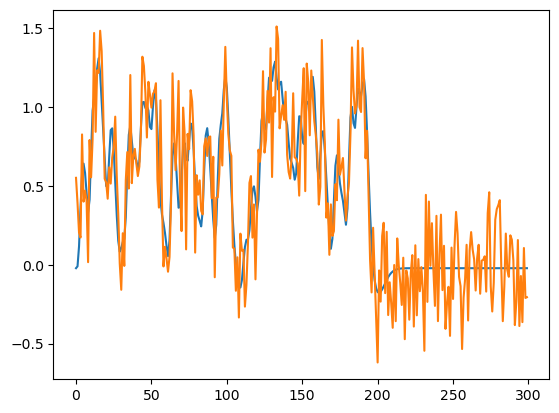

In [262]:
y_pred = glm.predict(glm_results.params)
plt.plot(y_pred)
plt.plot(y_obs)
# plt.plot(sc_conv)

In [272]:
glm_results.params


dur_0            0.511256
dur_17           1.595228
dur_33           1.603904
dur_67           2.831316
dur_134          3.784060
dur_267-isi_0    5.352046
dur_533          5.560521
isi_17           4.725830
isi_33           5.426909
isi_67           5.050509
isi_134          5.577967
isi_267          6.065968
isi_533          5.200515
intercept       -0.021449
dtype: float64

In [271]:
trials_ser = pd.Series(trials)
pd.DataFrame({'glm_weights' :glm_results.params, 'ground':trials_ser})

,glm_weights,ground
dur_0,0.511256,0.0
dur_134,3.784060,4.0
dur_17,1.595228,1.0
dur_267-isi_0,5.352046,5.0
dur_33,1.603904,2.0
dur_533,5.560521,6.0
dur_67,2.831316,3.0
intercept,-0.021449,NaN
isi_134,5.577967,5.5
isi_17,4.725830,5.0


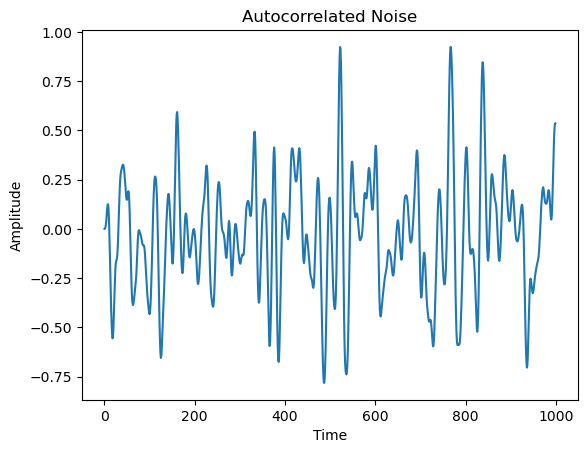

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import scipy.signal as signal

# Generate white noise
num_samples = 1000
white_noise = np.random.normal(size=num_samples)

# Design a low-pass filter
order = 4  # Filter order
cutoff_frequency = 0.1  # Adjust cutoff frequency as needed
b, a = signal.butter(order, cutoff_frequency, btype='low', analog=False)

# Apply the filter to the white noise to create autocorrelated noise
autocorrelated_noise = lfilter(b, a, white_noise)

# Plot the autocorrelated noise
plt.plot(autocorrelated_noise)
# plt.plot(white_noise)

plt.title('Autocorrelated Noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


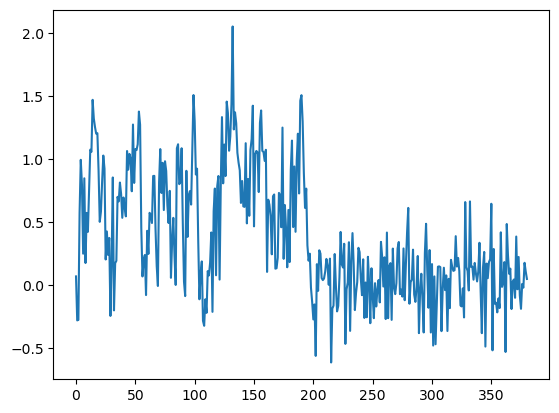

In [238]:
def add_noise(Y, SNR = 1):
    return Y + 1/SNR * np.random.normal(0, 1, size = len(Y))

plt.plot(add_noise(sc_conv, 4))

0.47577231437509315
2.021650372745322
3.084438978167908


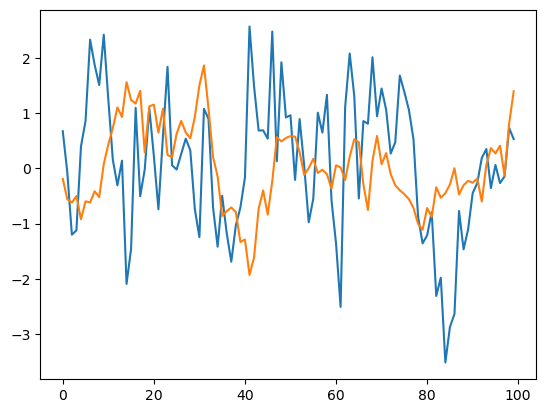

In [235]:
import numpy as np

def sample_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))

    return np.array(signal)

def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]

# Examples.
print(compute_corr_lag_1(sample_signal(5000, 0.5)))
print(np.mean(sample_signal(5000, 0.5, mu=2)))
print(np.std(sample_signal(5000, 0.5, sigma=3)))
plt.plot(sample_signal(5000, 0.5, sigma=1)[:100])
plt.plot(sample_signal(5000, 0.9, sigma=1)[:100])

In [23]:
equi_conv = convolve_HRF(equidistant, 5)

len()

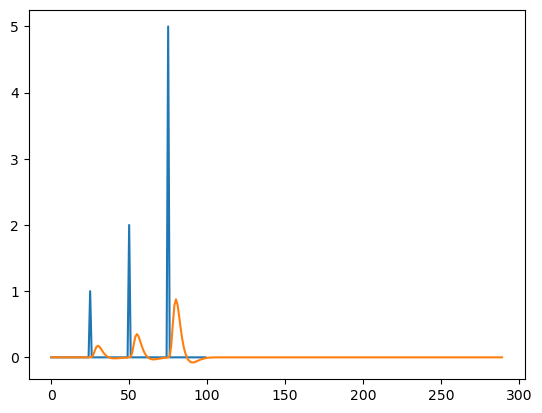

In [183]:
equidistant = np.zeros(100)
equidistant[25] = 1
equidistant[50] = 2
equidistant[75] = 5


equi_conv = convolve_HRF(equidistant, 1)

plt.plot(equidistant)
plt.plot(equi_conv)
# plt.xlim(25,50)

In [8]:
# defining the mapping, eyeballing from Zhou et al 2018

## in terms of multiples of the signal
{"dur" :{0 : 0,
        17 : 1,
        33 : 2,
        67 : 3,
        134: 4,
        267: 5,
        533: 6},

 "isi" : {0 : 5, # == 267
        17 : 5.1,
        33 : 5.3,
        67 : 5.5,
        134: 5.7,
        267: 5.8,
        533: 6}}

## in terms of % BOLD change
{"dur" :{0 : 0,
        17 : 1.01,
        33 : 1.02,
        67 : 1.03,
        134: 1.04,
        267: 1.05,
        533: 1.06},

 "isi" : {0 : 1.05, # == 267
        17 : 1.051,
        33 : 1.053,
        67 : 1.055,
        134: 1.057,
        267: 1.058,
        533: 1.06}}

## renaming some
trials = {"dur_0" : 0,
 "dur_17" : 1,
 "dur_33" : 2,
 "dur_67" : 3,
 "dur_134" : 4,
 "dur_267-isi_0" : 5,
 "dur_533" : 6,
 "isi_17" : 5,
 "isi_33" : 5.1,
 "isi_67" : 5.3,
 "isi_134" : 5.5,
 "isi_267" : 5.8,
 "isi_533" : 6}

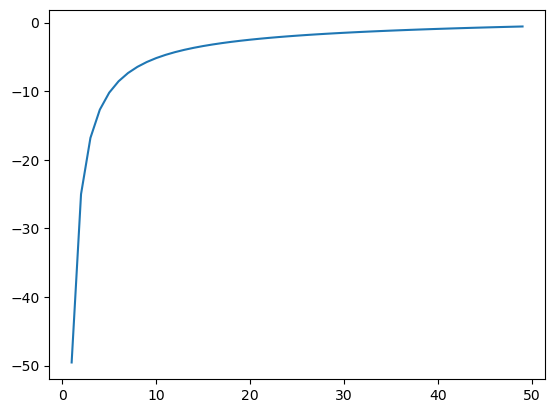

In [9]:
from scipy.special import digamma

plt.plot(digamma(np.linspace(0,1)))

from https://arxiv.org/pdf/2004.13361.pdf

## The canonical HRF

There exists several models to describe the functional shape of the HRF. As we mentioned above, one of the most widely used is the two-gamma distribution model [11](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=894ae718197c528700bc4c8bf9a3b94bf4be6a7d), usually referred to as the canonical HRF. In general, the canonical HRF in a parametric model that can be written as:

$$
h(t) = \frac{t^{a_1−1}e^{-a_2t}}{\Gamma(a_1)} - \alpha \frac{t^{a_3−1}e^{-a_4t}}{\Gamma(a_3)},
$$

where $\Gamma(\cdot)$ is the Gamma function, $\alpha$ controls the relative rati of response to undershoot, and $a_1$, $a_2$, $a_3$, and $a_4$ are four parameters that controls the functional shape of the HRF. Therefore, for this model, a total number of 5 parameters are required to define the HRF.

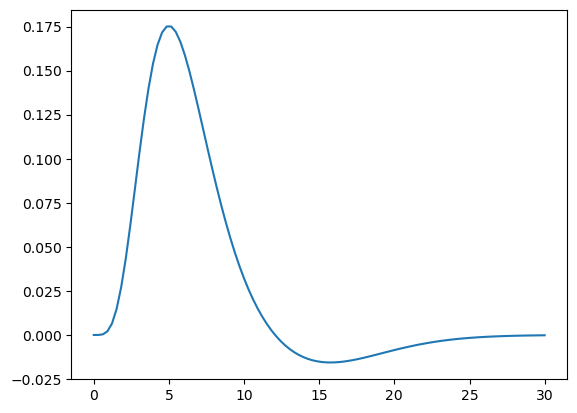

In [10]:
from scipy.special import gamma

def canHRF(t, a1=6, a2=1, a3=16, a4=1, alpha=1/6):
    """
    makes a canonical two-gamma HRF according to 
    
    $$
    h(t) = \frac{t^{a_1−1}e^{-a_2t}}{\Gamma(a_1)} - \alpha \frac{t^{a_3−1}e^{-a_4t}}{\Gamma(a_3)},
    $$
    
    t is the input time
    a1, a2, a3, a4 are shape params
    alpha controls the ratio of response to undershoot
    
    some plausible parameters are: alpha = 1/6, a1 = 6, 
    a3 = 16 and a2 = a4 = 1, see defaults, 
    which give a nice hrf returning to baseline after 25s
    """
    
    hrf = (t**(a1-1) * np.exp(-a2*t))/gamma(a1) - alpha * (t**(a3-1) * np.exp(-a4*t))/gamma(a3)
    return hrf

t = np.linspace(0, 30, 100)
plt.plot(t, canHRF(t))